### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
import matplotlib.pyplot as plt
from pathlib import Path
from mne import channels
from mne.io import read_info
from shared.utilities import SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, SAT2_STAGES_ACCURACY, SAT2_STAGES_SPEED, AR_STAGES
from shared.data import add_stages_to_dataset

2023-07-14 11:56:04.315169: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 11:56:04.793628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Short version using add_stages_to_dataset

Transforming epoched data to principal component (PC) space


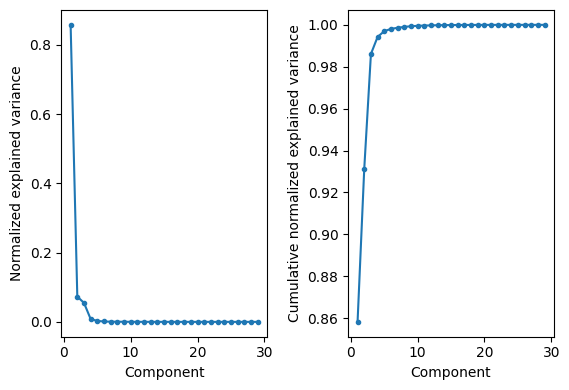

Fitting HMP model for AC condition


  0%|          | 0/89 [00:00<?, ?it/s]

Transition event 1 found around sample 25
Transition event 2 found around sample 59
Transition event 3 found around sample 88


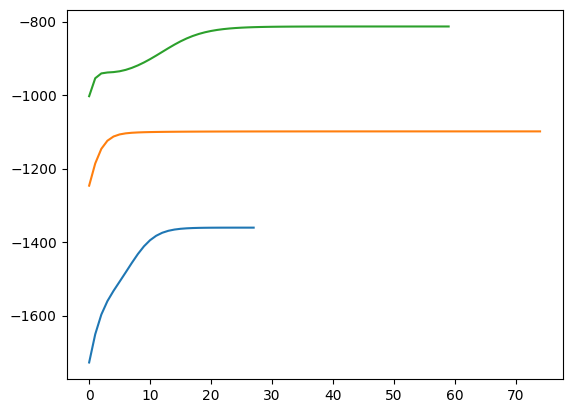

Estimating 3 events model
Parameters estimated for 3 events model
Labeling dataset for AC condition
Processing participant 0021
Processing participant 0022
Processing participant 0023
Processing participant 0024
Fitting HMP model for SP condition


  0%|          | 0/51 [00:00<?, ?it/s]

Transition event 1 found around sample 25
Transition event 2 found around sample 48


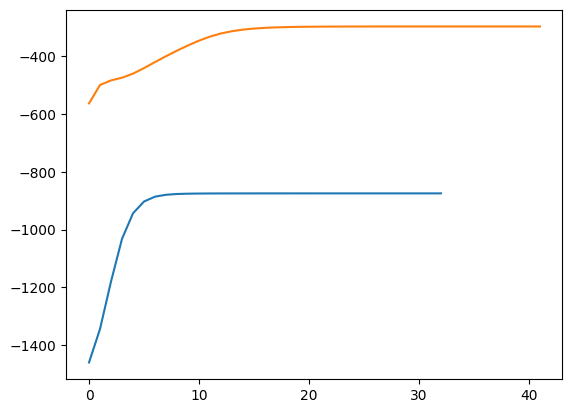

Estimating 2 events model
Parameters estimated for 2 events model
Labeling dataset for SP condition
Processing participant 0021
Processing participant 0022
Processing participant 0023
Processing participant 0024


In [5]:
# Amount of cores to use in multiprocessing
cpus = 12

epoched_data_path = Path("data/sat1/data.nc")
output_path = Path("data/sat1/stage_data.nc")
conditions = ["AC", "SP"]
labels = {"AC": SAT1_STAGES_ACCURACY[:-1], "SP": SAT1_STAGES_SPEED[:-1]}

stage_data = add_stages_to_dataset(
    epoched_data_path, output_path, labels, conditions=conditions, cpus=cpus
)

In [6]:
stage_data

<xarray.Dataset>
Dimensions:      (epochs: 200, channels: 30, samples: 199, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         (participant, epochs) float64 2.0 1.0 1.0 1.0 ... 2.0 1.0 1.0
    resp         (participant, epochs) object 'resp_right' ... 'resp_left'
    rt           (participant, epochs) float64 1.388 1.388 0.47 ... 0.317 0.756
    cue          (participant, epochs) object 'AC' 'AC' 'SP' ... 'AC' 'SP' 'AC'
    movement     (participant, epochs) object 'stim_right' ... 'stim_left'
    trigger      (participant, epochs) object 'AC/stim_right/resp_right' ... ...
  * participant  (participant) object '0021' '0022' '0023' '0024'
    labels       (participant, epochs, samples) object nan nan nan ... nan nan
Data variables:
    data         (participant, epochs, channels, samples) float64 -1.449 ... nan
Attributes:
    sfreq:    100.0
    offset:   0

### Manual version

In [7]:
# Amount of cores to use in multiprocessing
cpus = 12

# Load complete SAT1 dataset
eeg_data = xr.load_dataset("data/sat1/data.nc")

# Load x and y positions of electrodes
positions_path = Path("data/sat1/preprocessed/processed_0001_epo.fif")
positions = read_info(Path("data/sat1/preprocessed/processed_0001_epo.fif"))

output_path = Path("data/sat1/stage_data.nc")

In [8]:
eeg_data = eeg_data.sel(participant=["0021", "0022", "0023", "0024"])

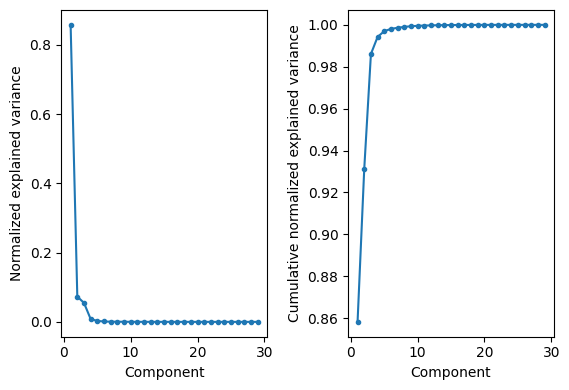

In [9]:
# Transform data into principal component (PC) space
# will ask in a pop-up how many components to keep
# selection depends on data size, choose number at cutoff (90/99%) or at 'elbow' point
hmp_data = hmp.utils.transform_data(eeg_data)

### Initialize models

In [10]:
hmp_accuracy_data = hmp.utils.condition_selection(
    hmp_data, eeg_data, "AC", variable="cue"
)
model_accuracy = hmp.models.hmp(
    hmp_accuracy_data,
    eeg_data,
    cpus=cpus,
    sfreq=eeg_data.sfreq,
    #  estimate_magnitudes=True
)


hmp_speed_data = hmp.utils.condition_selection(
    hmp_data, eeg_data, "SP", variable="cue")
model_speed = hmp.models.hmp(
    hmp_speed_data,
    eeg_data,
    cpus=cpus,
    sfreq=eeg_data.sfreq,
    #   estimate_magnitudes=True
)

#### Regular fitting

  0%|          | 0/89 [00:00<?, ?it/s]

Transition event 1 found around sample 25
Transition event 2 found around sample 59
Transition event 3 found around sample 88


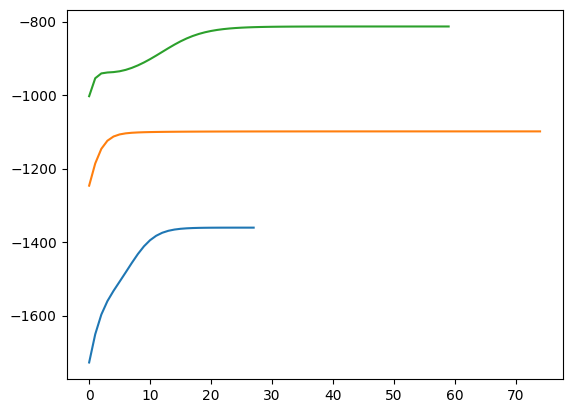

Estimating 3 events model
Parameters estimated for 3 events model


  0%|          | 0/51 [00:00<?, ?it/s]

Transition event 1 found around sample 25
Transition event 2 found around sample 48


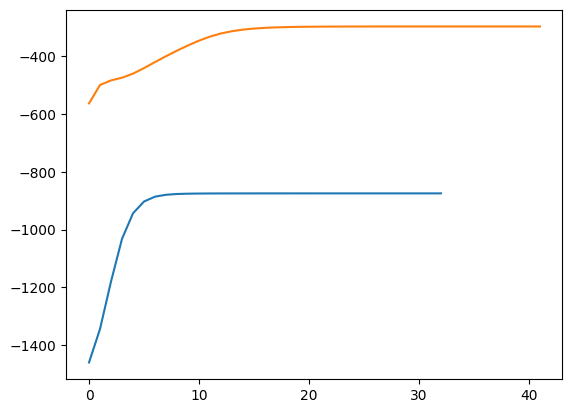

Estimating 2 events model
Parameters estimated for 2 events model


In [9]:
# Let model find stage transitions
fit_accuracy = model_accuracy.fit()
fit_speed = model_speed.fit()

In [5]:
# Tell model amount of events
fit_accuracy = model_accuracy.fit_single(4, starting_points=100)
fit_speed = model_speed.fit_single(3, starting_points=100)

Estimating 4 events model with 100 starting point(s)


Parameters estimated for 4 events model
Estimating 3 events model with 100 starting point(s)
Parameters estimated for 3 events model


In [6]:
acc_labels = label_model(fit_accuracy, eeg_data, SAT1_STAGES_ACCURACY)
sp_labels = label_model(fit_speed, eeg_data, SAT1_STAGES_SPEED)

Processing participant 0001
Processing participant 0002
Processing participant 0003
Processing participant 0004
Processing participant 0005
Processing participant 0006
Processing participant 0007
Processing participant 0008
Processing participant 0009
Processing participant 0010
Processing participant 0011
Processing participant 0012
Processing participant 0013
Processing participant 0014
Processing participant 0015
Processing participant 0016
Processing participant 0017
Processing participant 0018
Processing participant 0019
Processing participant 0020
Processing participant 0021
Processing participant 0022
Processing participant 0023
Processing participant 0024
Processing participant 0025
Processing participant 0001
Processing participant 0002
Processing participant 0003
Processing participant 0004
Processing participant 0005
Processing participant 0006
Processing participant 0007
Processing participant 0008
Processing participant 0009
Processing participant 0010
Processing participa

In [7]:
# Merge AC and SP condition labels (an epoch is either AC or SP so these are sets without common members)
merged = np.where(acc_labels == np.nan, sp_labels, acc_labels)
# Add stage info to eeg_data Dataset and save
stage_data = eeg_data.assign_coords(
    labels=(["participant", "epochs", "samples"], merged)
)
stage_data.to_netcdf(output_path)

# Debugging

In [10]:
# Check dataset size in MB
print(eeg_data.nbytes / (1024**2))
print(stage_data.nbytes / (1024**2))

227.9697723388672
235.56101989746094


In [33]:
stage_data.sel(participant="0021", epochs=1, samples=slice(1, 150)).labels

<xarray.DataArray 'labels' (samples: 150)>
array([nan, nan, nan, nan, 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'response', 'response', 'response', 'response',
       'response', 'response', 'response', 'response', 'response',
       'response', 'response', 'response', 'response', 'response',
       'response', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan], dtype=object)
Coordinates:
    epochs       int64 1
  * samples      (samples) int64 1 2 3 4 5 6 7 8 ... 144 145 146 147 148 149 150
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.388
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'
    labels       (samples) object nan nan nan nan 'encoding' ... nan nan nan nan

In [98]:
int(eeg_data.sel(participant="0021",
    epochs=1).isnull().argmax("samples").data[0])

139

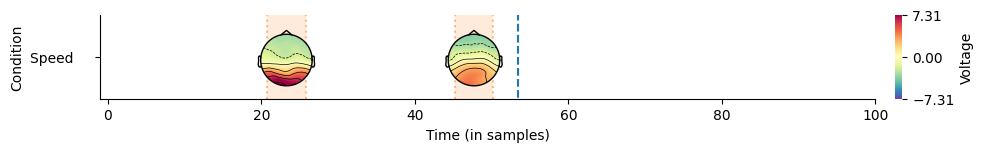

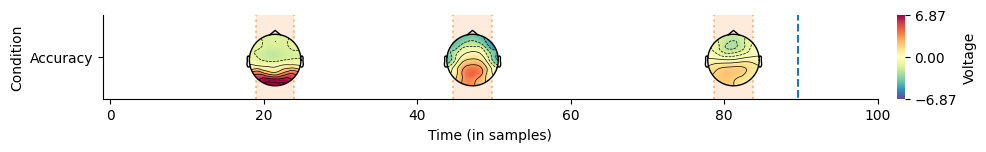

In [10]:
# Load x and y positions of electrodes
positions_path = Path("data/sat1/preprocessed/processed_0001_epo.fif")
positions = read_info(Path("data/sat1/preprocessed/processed_0001_epo.fif"))

for condition in zip(
    [fit_speed, fit_accuracy],
    [model_speed, model_accuracy],
    [hmp_speed_data, hmp_accuracy_data],
    ["Speed    ", "Accuracy"],
):
    hmp.visu.plot_topo_timecourse(
        eeg_data,
        condition[0],
        positions,
        condition[1],
        times_to_display=np.mean(condition[1].ends - condition[1].starts),
        max_time=100,
        figsize=(10, 1),
        ylabels={"Condition": [condition[3]]},
    )